In [275]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy

import numpy as np

In [276]:
from numpy.random import seed
from numpy.random import randn
from scipy.stats import anderson

from scipy.stats import boxcox
from scipy.special import inv_boxcox

from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro

In [277]:
inspector_results = pd.read_csv("mda_dataset.csv")
l2_results = pd.read_csv("l2_result_graph.csv")
taassc_results = pd.read_csv("result_taassc_graph.csv")
errors_data = pd.read_excel("dannye_novye.xlsx")


Преобразуем значения разных метрик для последующего слияния в единый датафрейм:

In [278]:
errors_data = errors_data.iloc[:-2]
errors_data = errors_data[["text_name", "errors"]]
errors_data.head(2)

,text_name,errors
0,exam2014/AAl_11_1.txt,1.0
1,exam2014/AAl_20_1.txt,1.0


In [279]:
def filter_num_words(text):
    if len(text.split()) >= 60:
        return True
    else:
        return False
    
inspector_results = inspector_results[inspector_results["type"] == 1]
del inspector_results["type"]
filter_arr = [filter_num_words(val) for val in inspector_results["text"].values]
inspector_results = inspector_results[filter_arr]

In [280]:
inspector_results.head(2)

,av_depth,max_depth,min_depth,num_acl,num_rel_cl,num_advcl,num_sent,num_tok,av_tok_before_root,av_len_sent,...,punct_mistakes_pp,punct_mistakes_because,punct_mistakes_but,punct_mistakes_compare,million_mistake,side_mistake,name,text,class,sum_punct
0,3.56,6,2,2,0,1,18,244,4.39,13.56,...,0,0,0,0,0,0,./data/exam/exam2017/OBy_146_1,This two line graphs illustrates monthly avera...,12,0
1,5.43,10,4,1,3,1,7,175,6.29,25.00,...,0,0,0,0,0,0,./data/exam/exam2017/EGe_15_1,"﻿We have two graphics, which show us the popul...",13,0


In [281]:
def fix_name(x):
    if x[20] == "_":
        x = x[:20] + x[22:]
    return x[12:] + ".txt"
    
    
inspector_results["text_name"] = inspector_results["name"].apply(fix_name)
# inspector_results

In [282]:
taassc_results["FILENAME"] = taassc_results["filename"]
del taassc_results["filename"]
# taassc_results

In [283]:
def fix_name(x):
    if x[20] == "_":
        x = x[:20] + x[22:]
    return x[12:] + ".txt"
    
    
inspector_results["text_name"] = inspector_results["name"].apply(fix_name)

In [284]:
inspector_results["FILENAME"] = [str(i) + ".txt" for i in list(range(len(inspector_results)))]


In [285]:
l2_results.head()

,Unnamed: 0,FILENAME,W,S,VP,C,T,DC,CT,CP,...,VP/T,C/T,DC/C,DC/T,T/S,CT/T,CP/T,CP/C,CN/T,CN/C
0,0,159.txt,272,11,25,21,12,8,6,7,...,2.0833,1.7500,0.3810,0.6667,1.0909,0.5000,0.5833,0.3333,3.0833,1.7619
1,1,158.txt,198,8,19,16,11,4,4,5,...,1.7273,1.4545,0.2500,0.3636,1.3750,0.3636,0.4545,0.3125,2.1818,1.5000
2,2,156.txt,193,10,16,15,11,2,2,6,...,1.4545,1.3636,0.1333,0.1818,1.1000,0.1818,0.5455,0.4000,2.0000,1.4667
3,3,157.txt,223,12,25,21,15,5,5,6,...,1.6667,1.4000,0.2381,0.3333,1.2500,0.3333,0.4000,0.2857,1.9333,1.3810
4,4,155.txt,186,13,23,19,16,3,3,5,...,1.4375,1.1875,0.1579,0.1875,1.2308,0.1875,0.3125,0.2632,1.0625,0.8947


In [286]:
full_data = inspector_results.merge(errors_data, on="text_name")

for col_name in taassc_results.columns:
    full_data[col_name] = taassc_results[col_name]
    
for col_name in l2_results.columns:
    full_data[col_name] = l2_results[col_name]

In [287]:
full_data.head(2)

,av_depth,max_depth,min_depth,num_acl,num_rel_cl,num_advcl,num_sent,num_tok,av_tok_before_root,av_len_sent,...,VP/T,C/T,DC/C,DC/T,T/S,CT/T,CP/T,CP/C,CN/T,CN/C
0,3.91,6,2,5,1,1,11,196,5.64,17.82,...,2.0833,1.7500,0.381,0.6667,1.0909,0.5000,0.5833,0.3333,3.0833,1.7619
1,7.22,14,3,7,3,8,9,301,4.22,33.44,...,1.7273,1.4545,0.250,0.3636,1.3750,0.3636,0.4545,0.3125,2.1818,1.5000


### Выделим только необходимые метрики из каждого инструмента:

In [288]:
s = "av_depth max_depth min_depth num_acl num_advcl num_sent num_tok av_tok_before_root av_len_sent num_cl num_tu num_compl_tu num_coord num_adj_noun num_part_noun num_noun_inf pos_sim_nei lemma_sim_nei pos_sim_all lemma_sim_all"
cols = [st for st in s.split()] + ["class"]

l2_must_have = ['MLS',
       'MLT', 'MLC', 'C/S', 'VP/T', 'C/T', 'DC/C', 'DC/T', 'T/S', 'CT/T',
       'CP/T', 'CP/C', 'CN/T', 'CN/C']

taassc_must_have = """acad_av_lemma_freq
acad_av_construction_freq
acad_av_lemma_construction_freq
acad_av_approx_collexeme
acad_av_faith_verb_cue
acad_av_faith_const_cue
acad_av_delta_p_verb_cue
acad_av_delta_p_const_cue
acad_av_lemma_freq_log
acad_av_construction_freq_log
acad_av_lemma_construction_freq_log
acad_av_lemma_freq_type
acad_av_construction_freq_type
acad_av_lemma_construction_freq_type
acad_av_approx_collexeme_type
acad_av_faith_verb_cue_type
acad_av_faith_const_cue_type
acad_av_delta_p_verb_cue_type
acad_av_delta_p_const_cue_type
acad_collexeme_ratio
acad_collexeme_ratio_type
acad_lemma_ttr
acad_construction_ttr
acad_lemma_construction_ttr
acad_lemma_attested
acad_construction_attested
acad_lemma_construction_attested
news_av_lemma_freq
news_av_construction_freq
news_av_lemma_construction_freq
news_av_approx_collexeme
news_av_faith_verb_cue
news_av_faith_const_cue
news_av_delta_p_verb_cue
news_av_delta_p_const_cue
news_av_lemma_freq_log
news_av_construction_freq_log
news_av_lemma_construction_freq_log
news_av_lemma_freq_type
news_av_construction_freq_type
news_av_lemma_construction_freq_type
news_av_approx_collexeme_type
news_av_faith_verb_cue_type
news_av_faith_const_cue_type
news_av_delta_p_verb_cue_type
news_av_delta_p_const_cue_type
news_collexeme_ratio
news_collexeme_ratio_type
news_lemma_ttr
news_construction_ttr
news_lemma_construction_ttr
news_lemma_attested
news_construction_attested
news_lemma_construction_attested
mag_av_lemma_freq
mag_av_construction_freq
mag_av_lemma_construction_freq
mag_av_approx_collexeme
mag_av_faith_verb_cue
mag_av_faith_const_cue
mag_av_delta_p_verb_cue
mag_av_delta_p_const_cue
mag_av_lemma_freq_log
mag_av_construction_freq_log
mag_av_lemma_construction_freq_log
mag_av_lemma_freq_type
mag_av_construction_freq_type
mag_av_lemma_construction_freq_type
mag_av_approx_collexeme_type
mag_av_faith_verb_cue_type
mag_av_faith_const_cue_type
mag_av_delta_p_verb_cue_type
mag_av_delta_p_const_cue_type
mag_collexeme_ratio
mag_collexeme_ratio_type
mag_lemma_ttr
mag_construction_ttr
mag_lemma_construction_ttr
mag_lemma_attested
mag_construction_attested
mag_lemma_construction_attested
fic_av_lemma_freq
fic_av_construction_freq
fic_av_lemma_construction_freq
fic_av_approx_collexeme
fic_av_faith_verb_cue
fic_av_faith_const_cue
fic_av_delta_p_verb_cue
fic_av_delta_p_const_cue
fic_av_lemma_freq_log
fic_av_construction_freq_log
fic_av_lemma_construction_freq_log
fic_av_lemma_freq_type
fic_av_construction_freq_type
fic_av_lemma_construction_freq_type
fic_av_approx_collexeme_type
fic_av_faith_verb_cue_type
fic_av_faith_const_cue_type
fic_av_delta_p_verb_cue_type
fic_av_delta_p_const_cue_type
fic_collexeme_ratio
fic_collexeme_ratio_type
fic_lemma_ttr
fic_construction_ttr
fic_lemma_construction_ttr
fic_lemma_attested
fic_construction_attested
fic_lemma_construction_attested
all_av_lemma_freq
all_av_construction_freq
all_av_lemma_construction_freq
all_av_approx_collexeme
all_av_faith_verb_cue
all_av_faith_const_cue
all_av_delta_p_verb_cue
all_av_delta_p_const_cue
all_av_lemma_freq_log
all_av_construction_freq_log
all_av_lemma_construction_freq_log
all_av_lemma_freq_type
all_av_construction_freq_type
all_av_lemma_construction_freq_type
all_av_approx_collexeme_type
all_av_faith_verb_cue_type
all_av_faith_const_cue_type
all_av_delta_p_verb_cue_type
all_av_delta_p_const_cue_type
all_collexeme_ratio
all_collexeme_ratio_type
all_lemma_ttr
all_construction_ttr
all_lemma_construction_ttr
all_lemma_attested
all_construction_attested
all_lemma_construction_attested
all_av_lemma_freq_stdev
all_av_construction_freq_stdev
all_av_lemma_construction_freq_stdev
all_av_approx_collexeme_stdev
all_av_faith_verb_cue_stdev
all_av_faith_const_cue_stdev
all_av_delta_p_verb_cue_stdev
all_av_delta_p_const_cue_stdev
acad_av_lemma_freq_stdev
acad_av_construction_freq_stdev
acad_av_lemma_construction_freq_stdev
acad_av_approx_collexeme_stdev
acad_av_faith_verb_cue_stdev
acad_av_faith_const_cue_stdev
acad_av_delta_p_verb_cue_stdev
acad_av_delta_p_const_cue_stdev
news_av_lemma_freq_stdev
news_av_construction_freq_stdev
news_av_lemma_construction_freq_stdev
news_av_approx_collexeme_stdev
news_av_faith_verb_cue_stdev
news_av_faith_const_cue_stdev
news_av_delta_p_verb_cue_stdev
news_av_delta_p_const_cue_stdev
mag_av_lemma_freq_stdev
mag_av_construction_freq_stdev
mag_av_lemma_construction_freq_stdev
mag_av_approx_collexeme_stdev
mag_av_faith_verb_cue_stdev
mag_av_faith_const_cue_stdev
mag_av_delta_p_verb_cue_stdev
mag_av_delta_p_const_cue_stdev
fic_av_lemma_freq_stdev
fic_av_construction_freq_stdev
fic_av_lemma_construction_freq_stdev
fic_av_approx_collexeme_stdev
fic_av_faith_verb_cue_stdev
fic_av_faith_const_cue_stdev
fic_av_delta_p_verb_cue_stdev
fic_av_delta_p_const_cue_stdev
all_av_lemma_freq_log_stdev
all_av_construction_freq_log_stdev
all_av_lemma_construction_freq_log_stdev
acad_av_lemma_freq_log_stdev
acad_av_construction_freq_log_stdev
acad_av_lemma_construction_freq_log_stdev
news_av_lemma_freq_log_stdev
news_av_construction_freq_log_stdev
news_av_lemma_construction_freq_log_stdev
mag_av_lemma_freq_log_stdev
mag_av_construction_freq_log_stdev
mag_av_lemma_construction_freq_log_stdev
fic_av_lemma_freq_log_stdev
fic_av_construction_freq_log_stdev
fic_av_lemma_construction_freq_log_stdev"""

taassc_must_have = taassc_must_have.split("\n")


must_have_cols = cols + l2_must_have + list(taassc_must_have) + ["errors"]
len(must_have_cols)

226

In [289]:
for col_name in full_data.columns:
    if col_name not in must_have_cols:
        del full_data[col_name]

### Посмотрим, сколько эссе содержится в каждом классе

In [290]:
print(set(full_data["class"].values))
[(i, len(full_data[full_data["class"] == i])) for i in 
     set(full_data["class"].values)]

{5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17}


[(5, 2),
 (7, 3),
 (8, 6),
 (9, 14),
 (10, 48),
 (11, 110),
 (12, 155),
 (13, 88),
 (14, 31),
 (15, 8),
 (17, 1)]

In [291]:
print(set(full_data["errors"].values))
[(i, len(full_data[full_data["errors"] == i])) for i in 
     set(full_data["errors"].values)]

{1.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 14.0, 15.0, 19.0}


[(1.0, 276),
 (4.0, 70),
 (5.0, 53),
 (6.0, 19),
 (7.0, 22),
 (8.0, 10),
 (9.0, 5),
 (10.0, 3),
 (11.0, 4),
 (12.0, 1),
 (14.0, 1),
 (15.0, 1),
 (19.0, 1)]

### Отбросим группы, в которых слишком мало данных

In [292]:
full_data_error = full_data.copy()

In [293]:
full_data_error = full_data_error[full_data["errors"] <= 11]


In [294]:
full_data = full_data[full_data["class"] != 3]
full_data = full_data[full_data["class"] != 4]
full_data = full_data[full_data["class"] != 5]
full_data = full_data[full_data["class"] != 6]
full_data = full_data[full_data["class"] != 7]
full_data = full_data[full_data["class"] != 8]
full_data = full_data[full_data["class"] != 15]
full_data = full_data[full_data["class"] != 16]
full_data = full_data[full_data["class"] != 17]

### Удалим мультиколлинеарные переменные, то есть для тех независимых переменных, у которых абсолютное значение коллинеарности по Спирмену больше, чем 0.7 возьмём ту метрику, которая показывает максимальный коэффициент корреляции с зависимой переменной

##### Сначала удалим коррелирующие переменные для зависимого столбца 'class':

In [295]:
filtered_data = full_data
del filtered_data["errors"]

In [296]:
while True:
    class_col_index = [i for i, j in enumerate(filtered_data.columns) if j == "class"][0]
    corr_mat = filtered_data.corr("spearman").values
    col_to_del = set()
    
    
    for i, col_name in enumerate(filtered_data.columns):
        buff_arr = []
        for j, col_name_2 in enumerate(filtered_data.columns):
            if i == j:
                continue
            if corr_mat[i][j] > 0.7:
                buff_arr.append((j, col_name_2))
        if len(buff_arr) > 0:
            buff_arr.append((i, col_name))
            break
    
    if len(buff_arr) == 0:
        break
    max_val = 0.0
    max_col = None
    for j, col in buff_arr:
        if corr_mat[class_col_index][j] > max_val:
            max_val = corr_mat[class_col_index][j]
            max_col = col
    col_to_del = col_to_del.union(set([i for _, i in buff_arr]))
    col_to_del -= set([max_col])
    
    for col in col_to_del:
        del filtered_data[col]


### Рассмотрим матрицу корреляции Спирмена, чтобы убедиться в отсутствии мультиколлинеарности между независимыми переменными

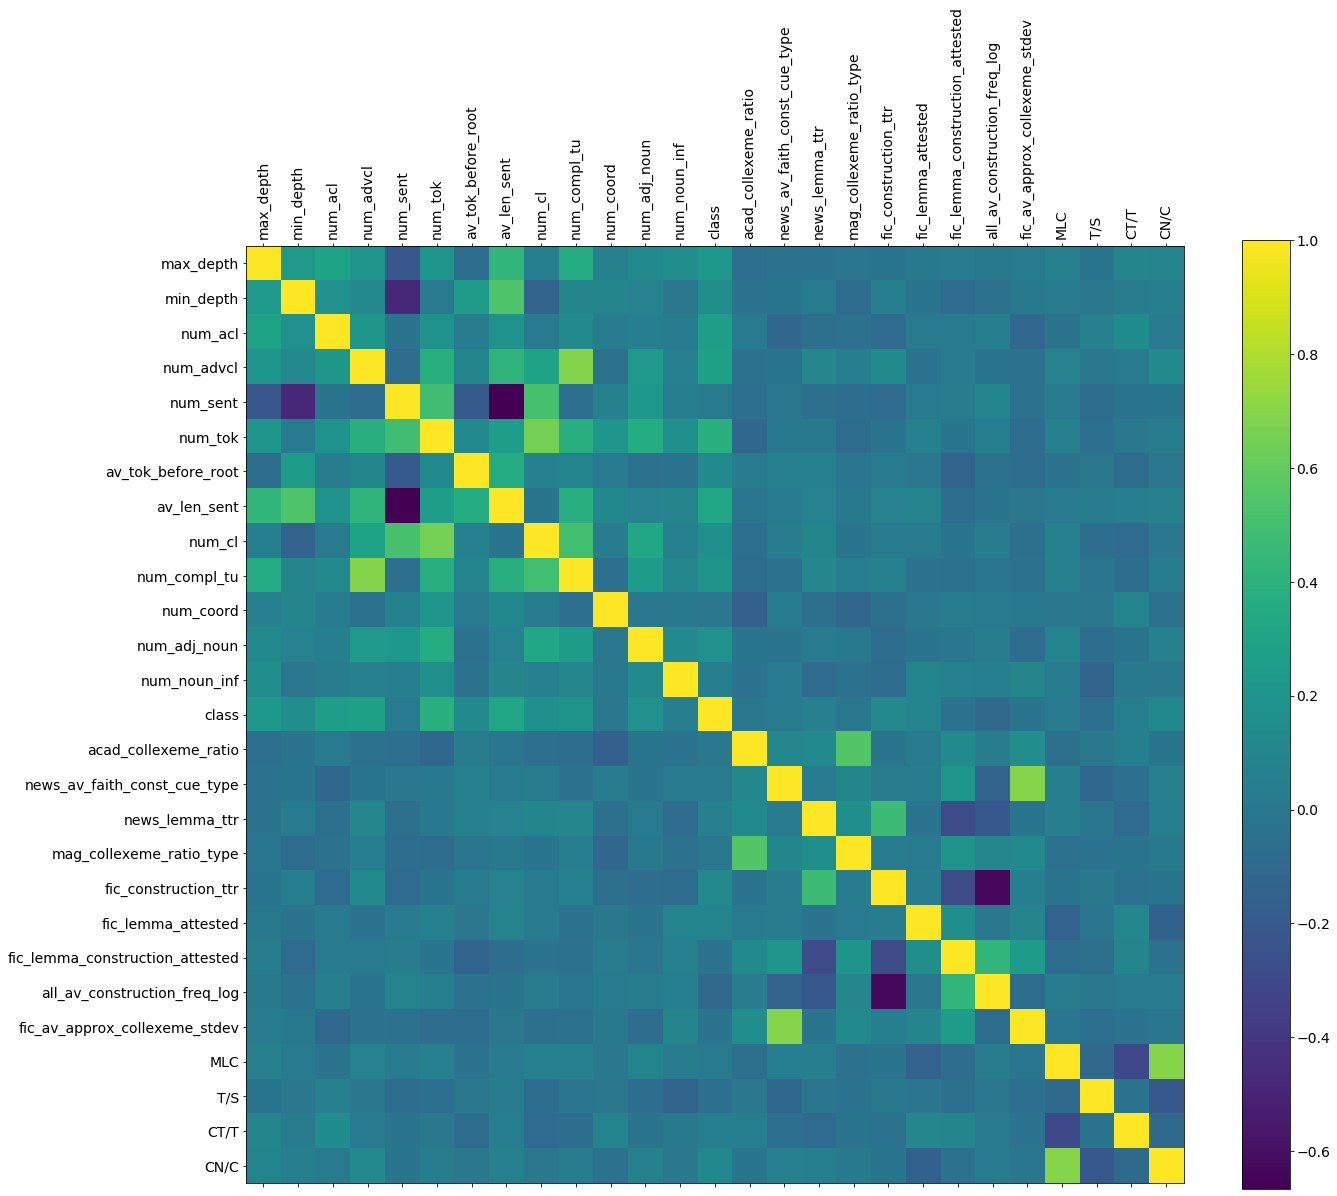

In [297]:
f = plt.figure(figsize=(21, 17))
plt.matshow(filtered_data.corr("spearman"), fignum=f.number)
plt.xticks(range(filtered_data.select_dtypes(['number']).shape[1]),
           filtered_data.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(filtered_data.select_dtypes(['number']).shape[1]),
           filtered_data.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title(' ', fontsize=16);

In [298]:
filtered_data

,max_depth,min_depth,num_acl,num_advcl,num_sent,num_tok,av_tok_before_root,av_len_sent,num_cl,num_compl_tu,...,mag_collexeme_ratio_type,fic_construction_ttr,fic_lemma_attested,fic_lemma_construction_attested,all_av_construction_freq_log,fic_av_approx_collexeme_stdev,MLC,T/S,CT/T,CN/C
0,6,2,5,1,11,196,5.64,17.82,18,3,...,5.000000,0.857143,1.000000,0.722222,4.913453,10214.956217,12.9524,1.0909,0.5000,1.7619
1,14,3,7,8,9,301,4.22,33.44,36,11,...,3.333333,0.708333,0.962963,0.703704,4.919330,3311.645218,12.3750,1.3750,0.3636,1.5000
2,7,3,5,3,8,174,5.88,21.75,13,3,...,0.000000,0.666667,1.000000,0.600000,4.847445,0.000000,12.8667,1.1000,0.1818,1.4667
3,6,2,1,2,10,241,6.70,24.10,16,1,...,3.000000,1.000000,1.000000,0.312500,3.188643,11890.900293,10.6190,1.2500,0.3333,1.3810
4,4,2,0,4,11,230,6.36,20.91,17,3,...,3.000000,0.888889,1.000000,0.636364,4.921985,14850.312468,9.7895,1.2308,0.1875,0.8947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,7,2,0,2,10,203,4.20,20.30,19,5,...,6.000000,0.666667,1.000000,0.500000,4.915644,8435.715788,8.9000,1.0909,0.4167,1.4000
462,6,3,4,1,10,179,4.90,17.90,13,1,...,0.000000,1.000000,1.000000,0.692308,4.570030,9096.162792,11.7692,1.0000,0.5000,1.9231
463,7,3,3,2,9,181,3.67,20.11,9,2,...,1.333333,0.600000,1.000000,0.764706,5.007290,16851.614184,10.2308,1.2000,0.8333,1.1538
464,6,2,0,2,13,202,5.54,15.54,16,2,...,4.000000,0.736842,1.000000,0.652174,4.785854,6210.145215,11.2857,0.9333,0.3571,1.6190


### Отсортируем значения коэффициента корреляции с зависимой переменной для оценки:

In [299]:
class_col_index = [i for i, j in enumerate(filtered_data.columns) if j == "class"][0]


corr_mat = filtered_data.corr("spearman").values[class_col_index, :]
corr_mat_kend = filtered_data.corr("kendall").values[class_col_index, :]
res_dict = {}
for i, colname in enumerate(filtered_data.corr("spearman").columns):
    res_dict[colname] = (round(corr_mat[i], 3), round(corr_mat_kend[i], 3))


In [300]:
print("\t (Spearman, Kendal)\n")

for col, val in sorted(res_dict.items(), key=lambda x: -np.abs(x[1][0])):
    print(col,":  ", val)

	 (Spearman, Kendal)

class :   (1.0, 1.0)
num_tok :   (0.392, 0.303)
av_len_sent :   (0.312, 0.235)
num_advcl :   (0.29, 0.235)
num_acl :   (0.267, 0.209)
max_depth :   (0.219, 0.176)
num_compl_tu :   (0.194, 0.152)
num_adj_noun :   (0.175, 0.134)
num_cl :   (0.17, 0.131)
min_depth :   (0.155, 0.131)
av_tok_before_root :   (0.132, 0.098)
fic_construction_ttr :   (0.116, 0.09)
CN/C :   (0.111, 0.081)
all_av_construction_freq_log :   (-0.088, -0.066)
fic_lemma_attested :   (0.085, 0.072)
news_lemma_ttr :   (0.057, 0.042)
T/S :   (-0.057, -0.045)
CT/T :   (0.054, 0.04)
num_noun_inf :   (0.051, 0.045)
fic_lemma_construction_attested :   (-0.032, -0.024)
news_av_faith_const_cue_type :   (0.028, 0.022)
MLC :   (0.028, 0.019)
fic_av_approx_collexeme_stdev :   (-0.026, -0.019)
num_sent :   (0.014, 0.011)
num_coord :   (-0.008, -0.006)
acad_collexeme_ratio :   (0.003, 0.003)
mag_collexeme_ratio_type :   (0.001, 0.001)


In [301]:
from scipy import stats

print("Colname:  Spearman p-value:   Kendall p-value:")
for col in filtered_data.columns:
    val = filtered_data[col].values
    print(col, "      ", round(stats.spearmanr(val, filtered_data["class"].values)[1], 4), "      ", 
    round(stats.kendalltau(val, filtered_data["class"].values)[1], 4))

Colname:  Spearman p-value:   Kendall p-value:
max_depth        0.0        0.0
min_depth        0.001        0.0011
num_acl        0.0        0.0
num_advcl        0.0        0.0
num_sent        0.7624        0.7694
num_tok        0.0        0.0
av_tok_before_root        0.0051        0.0051
av_len_sent        0.0        0.0
num_cl        0.0003        0.0003
num_compl_tu        0.0        0.0
num_coord        0.8626        0.8658
num_adj_noun        0.0002        0.0002
num_noun_inf        0.2796        0.2756
class        0.0        0.0
acad_collexeme_ratio        0.948        0.9404
news_av_faith_const_cue_type        0.55        0.5375
news_lemma_ttr        0.2308        0.2304
mag_collexeme_ratio_type        0.9801        0.9828
fic_construction_ttr        0.0145        0.0128
fic_lemma_attested        0.072        0.073
fic_lemma_construction_attested        0.5006        0.4984
all_av_construction_freq_log        0.0619        0.061
fic_av_approx_collexeme_stdev        0.5783    

### Сделаем те же самые шаги для выявления корреляции с количеством синтаксических ошибок:

Удалим линейно зависимые переменные

In [302]:
filtered_data = full_data_error.copy()
del filtered_data["class"]

In [303]:

while True:
    class_col_index = [i for i, j in enumerate(filtered_data.columns) if j == "errors"][0]
    corr_mat = filtered_data.corr("spearman").values
    col_to_del = set()
    
    for i, col_name in enumerate(filtered_data.columns):
        buff_arr = []
        for j, col_name_2 in enumerate(filtered_data.columns):
            if i == j:
                continue
            if corr_mat[i][j] > 0.7:
                buff_arr.append((j, col_name_2))
        if len(buff_arr) > 0:
            buff_arr.append((i, col_name))
            break
    
    if len(buff_arr) == 0:
        break
    max_val = 0.0
    max_col = None
    for j, col in buff_arr:
        if corr_mat[class_col_index][j] > max_val:
            max_val = corr_mat[class_col_index][j]
            max_col = col
    col_to_del = col_to_del.union(set([i for _, i in buff_arr]))
#     print(col_to_del)
    col_to_del -= set([max_col])
    
    for col in col_to_del:
        del filtered_data[col]

### Посмотрим матрицу корреляции

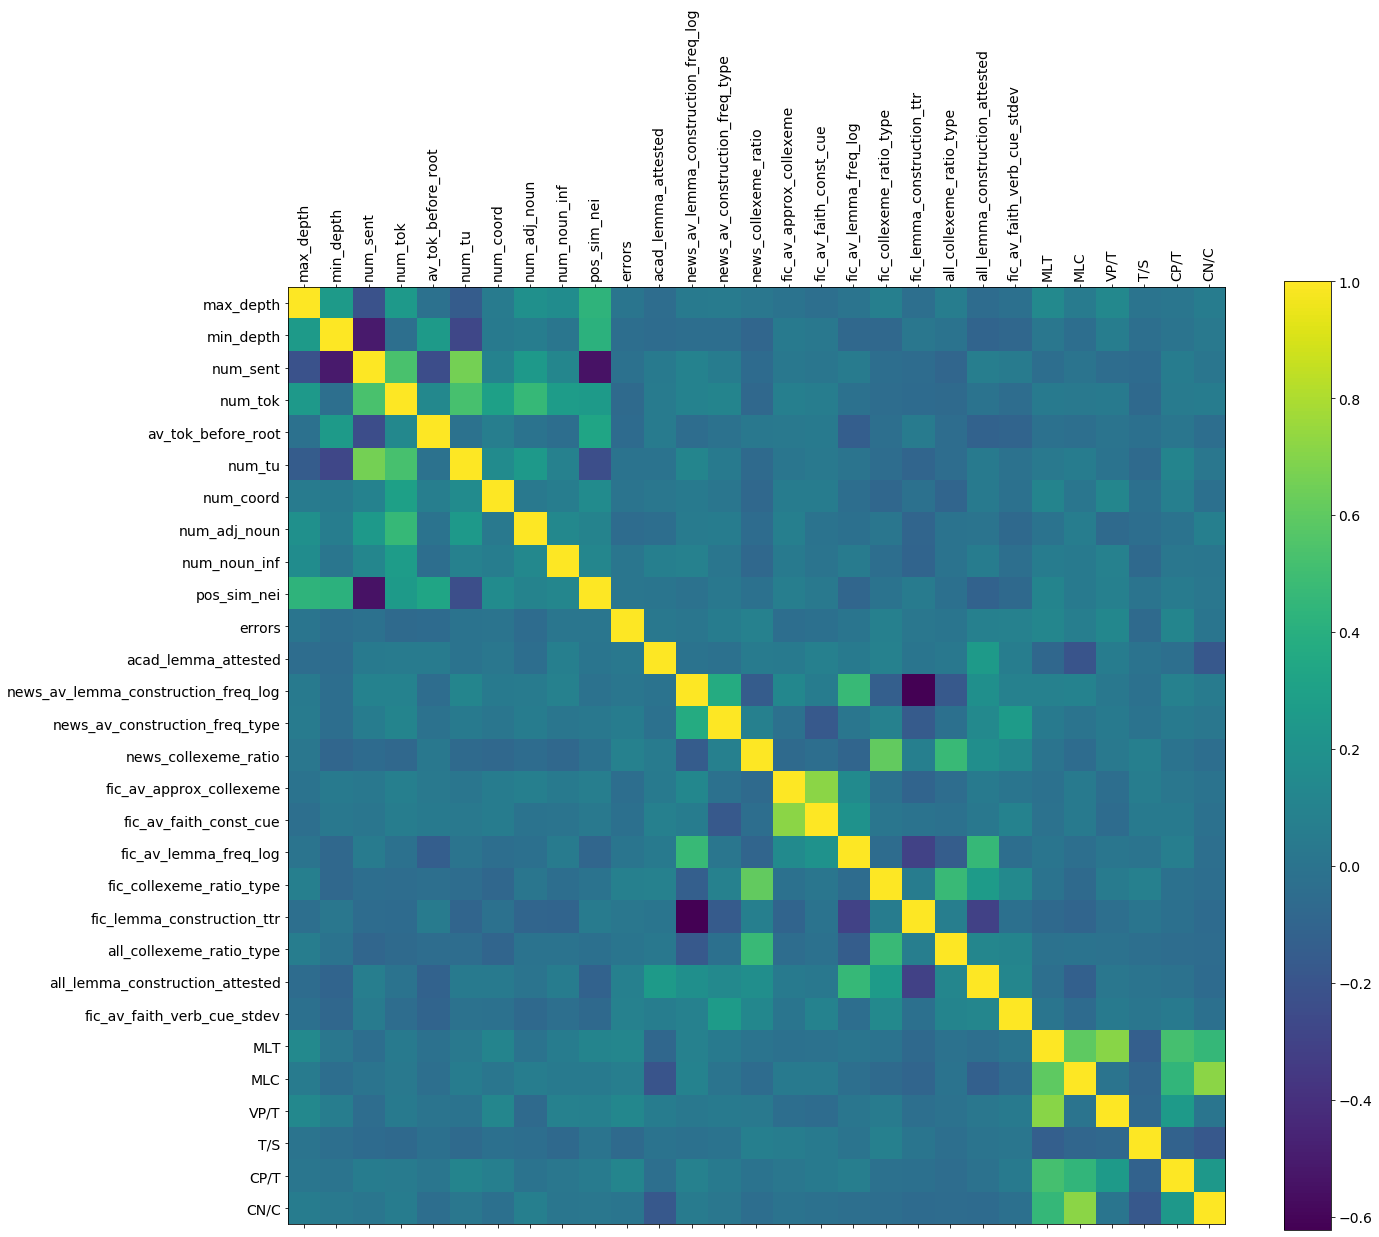

In [304]:
f = plt.figure(figsize=(21, 17))
plt.matshow(filtered_data.corr(), fignum=f.number)
plt.xticks(range(filtered_data.select_dtypes(['number']).shape[1]),
           filtered_data.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(filtered_data.select_dtypes(['number']).shape[1]),
           filtered_data.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title(' ', fontsize=16);

### Отсортируем значения коэффициента корреляции с зависимой переменной для количества синтаксических ошибок:

In [305]:
class_col_index = [i for i, j in enumerate(filtered_data.columns) if j == "errors"][0]


corr_mat = filtered_data.corr("spearman").values[class_col_index, :]
corr_mat_kend = filtered_data.corr("kendall").values[class_col_index, :]
res_dict = {}
for i, colname in enumerate(filtered_data.corr("spearman").columns):
    res_dict[colname] = (round(corr_mat[i], 3), round(corr_mat_kend[i], 3))

In [306]:
print("\t (Spearman, Kendal)\n")

for col, val in sorted(res_dict.items(), key=lambda x: -np.abs(x[1][0])):
    print(col,":  ", val)

	 (Spearman, Kendal)

errors :   (1.0, 1.0)
CP/T :   (0.117, 0.09)
all_lemma_construction_attested :   (0.09, 0.069)
VP/T :   (0.088, 0.068)
fic_av_faith_verb_cue_stdev :   (0.081, 0.061)
fic_av_approx_collexeme :   (0.072, 0.052)
MLT :   (0.072, 0.054)
fic_collexeme_ratio_type :   (0.07, 0.056)
av_tok_before_root :   (-0.067, -0.051)
num_tok :   (-0.063, -0.048)
news_collexeme_ratio :   (0.06, 0.048)
num_adj_noun :   (-0.057, -0.044)
fic_av_faith_const_cue :   (0.055, 0.039)
news_av_construction_freq_type :   (0.054, 0.04)
MLC :   (0.046, 0.034)
acad_lemma_attested :   (0.04, 0.034)
T/S :   (-0.037, -0.03)
min_depth :   (-0.036, -0.031)
CN/C :   (0.031, 0.023)
fic_av_lemma_freq_log :   (0.022, 0.017)
all_collexeme_ratio_type :   (0.022, 0.017)
num_noun_inf :   (0.021, 0.019)
num_coord :   (0.017, 0.013)
news_av_lemma_construction_freq_log :   (0.013, 0.011)
max_depth :   (-0.012, -0.01)
fic_lemma_construction_ttr :   (0.01, 0.009)
num_tu :   (0.009, 0.007)
pos_sim_nei :   (0.005, 0.00

In [308]:
from scipy import stats

print("Colname:  Spearman p-value:   Kendall p-value:")
for col in filtered_data.columns:
    val = filtered_data[col].values
    print(col, "      ", round(stats.spearmanr(val, filtered_data["errors"].values)[1], 4), "      ", 
    round(stats.kendalltau(val, filtered_data["errors"].values)[1], 4))

Colname:  Spearman p-value:   Kendall p-value:
max_depth        0.797        0.7987
min_depth        0.4463        0.4496
num_sent        0.96        0.9644
num_tok        0.1776        0.1791
av_tok_before_root        0.1491        0.1512
num_tu        0.8467        0.8492
num_coord        0.723        0.7304
num_adj_noun        0.2233        0.2337
num_noun_inf        0.656        0.655
pos_sim_nei        0.9166        0.9355
errors        0.0        0.0
acad_lemma_attested        0.3937        0.3963
news_av_lemma_construction_freq_log        0.779        0.7665
news_av_construction_freq_type        0.2485        0.2563
news_collexeme_ratio        0.1978        0.1996
fic_av_approx_collexeme        0.123        0.1428
fic_av_faith_const_cue        0.2399        0.2712
fic_av_lemma_freq_log        0.6325        0.6377
fic_collexeme_ratio_type        0.1308        0.1343
fic_lemma_construction_ttr        0.8237        0.82
all_collexeme_ratio_type        0.6441        0.6532
all_lemma

In [307]:
from matplotlib.pyplot import figure

# fig, ax = plt.subplots()
# figure(figsize=(8, 6), dpi=80)


res = []
for i in sorted_class:
    res.append(inspector_results[inspector_results["class"] == i]["pos_sim_all"].mean())
    

# plt.errorbar(list(set(inspector_results["class"].values)),
#             res,
#             label='pos_sim_all')

plt.errorbar(list(set(inspector_results["class"].values)),
            inspector_results.groupby('class')["pos_sim_all"].mean().values,
            label='pos_sim_all')

plt.errorbar(list(set(inspector_results["class"].values)),
            inspector_results.groupby('class')["av_len_sent"].mean().values,
            label='av_len_sent')

plt.errorbar(list(set(inspector_results["class"].values)),
            inspector_results.groupby('class')["av_depth"].mean().values,
            label='av_depth')

plt.errorbar(list(set(inspector_results["class"].values)),
            inspector_results.groupby('class')["av_tok_before_root"].mean().values,
            label='av_tok_before_root')

plt.errorbar(list(set(inspector_results["class"].values)),
            inspector_results.groupby('class')["det_pobj_deps_NN_struct"].mean().values,
            label='det_pobj_deps_NN_struct')
plt.legend(loc='best')
plt.show()

NameError: name 'sorted_class' is not defined

In [ ]:
from matplotlib.pyplot import figure


fig, axs = plt.subplots(2, 2, figsize=(14, 8))

# fig.figure(figsize=(8, 6), dpi=80)
fig.suptitle('Top metric mean value')

axs[0][0].plot(list(set(inspector_results["class"].values)),
            inspector_results.groupby('class')["pos_sim_all"].mean().values)
axs[0, 0].set_title("pos_sim_all")

axs[0][1].plot(list(set(inspector_results["class"].values)),
            inspector_results.groupby('class')["av_len_sent"].mean().values)
axs[0, 1].set_title("av_len_sent")

axs[1][0].plot(list(set(inspector_results["class"].values)),
            inspector_results.groupby('class')["av_depth"].mean().values)
axs[1, 0].set_title("av_depth")

axs[1][1].plot(list(set(inspector_results["class"].values)),
            inspector_results.groupby('class')["av_tok_before_root"].mean().values)
axs[1, 1].set_title("av_tok_before_root")
